#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
imgs = th.rand(size=(13, 3, 100, 100))
bboxes = th.rand(size=(16, 4))
labels = th.randint(0, 2, size=(16, ))

In [ ]:
class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        n_features = 64 * 49 * 49
        self.classifier = nn.Sequential(
            nn.Linear(n_features,64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.regressor = nn.Sequential(
            nn.Linear(n_features,64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
    def forward(self, X):
        features = self.backbone(X).flatten(start_dim=1)
        return self.classifier(features), self.regressor(features)

In [ ]:
model = Detector()
label_pred, bbox_pred = model(imgs)

In [ ]:
import torch.nn.functional as F

F.cross_entropy(label_pred, labels)
F.mse_loss(bbox_pred, bboxes)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [x] Проверено на семинаре

In [ ]:
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iMiozDuYhsZytw

--2023-12-10 19:06:19--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iMiozDuYhsZytw
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/fbdf8ef014e4daf8ff946dcf028d7d56480e6a0477eaf0a503a041aaf06867b2/657635c4/plIt5EuDWKnuXPQDyGsykJoKe6AvIOfQRASRgfs9d62XouTbS7eqhONGW2flp--jr9Cot5KbNrMSSnhYmZYZRg%3D%3D?uid=0&filename=animals.zip&disposition=attachment&hash=NhNqFL/rPXk9WFWegJ1lDIWCBnuxCoAbUsWujgl/WLfkzQZRFb8LMNVg7a%2BywOaXq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=982420194&fsize=25404614&hid=9f355e52fd76a2fed94fc0b7e66da82c&media_type=compressed&tknv=v2 [following]
--2023-12-10 19:06:20--  https://downloader.disk.yandex.ru/disk/fbdf8ef014e4daf8ff946dcf028d7d56480e6a0477eaf0a503a041aaf06867b2/657635c4/plIt5EuDWKnuXPQDyGsykJoKe6AvI

In [ ]:
from zipfile import ZipFile

with ZipFile('iMiozDuYhsZytw') as f:
  f.extractall()

In [ ]:
from bs4 import BeautifulSoup

def parse_xml(file):
    info = {}
    coord = {}
    normed_coord = {}
    l = ['name', 'xmin', 'ymin', 'xmax', 'ymax']
    with open(file) as fp:
        soup = BeautifulSoup(fp)
    width = float(soup.find('width').text)
    height = float(soup.find('height').text)
    for i in l:
        if i == 'name':
            info['obj_name'] =soup.find(i).text
        else:
            coord[i] = float(soup.find(i).text)
            normed_coord[i] = float(soup.find(i).text) / width if 'x' in i else float(soup.find(i).text) / height
    info['raw'] = coord
    info['normed'] = normed_coord
    return info

In [ ]:
parse_xml('/content/Asirra: cat vs dogs/dog.174.xml')

{'obj_name': 'dog',
 'raw': {'xmin': 7.0, 'ymin': 19.0, 'xmax': 121.0, 'ymax': 183.0},
 'normed': {'xmin': 0.027131782945736434,
  'ymin': 0.10160427807486631,
  'xmax': 0.4689922480620155,
  'ymax': 0.7093023255813954}}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchtext.transforms as TT
import os
from PIL import Image

class AnimalDetectionDataset(Dataset):
    def __init__(self, root, transforms=T.Compose([T.PILToTensor()]), target_transform = None, return_scaled=True):
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        self.images = []
        self.info = []
        for file_ in sorted(os.listdir(root)):
            if file_.endswith('.jpg'):
                self.images.append(root + '/' + file_)
            elif file_.endswith('.xml'):
                self.info.append(root + '/' + file_)

    def read_image(self, img):
        image = Image.open(img)
        return image

    def __getitem__(self, idx):
        img = self.read_image(self.images[idx])
        inf = parse_xml(self.info[idx])
        if self.target_transform is not None:
            if self.return_scaled:
                return self.transforms(img), self.target_transform([inf['obj_name']]), inf['normed']
            else:
                return self.transforms(img), self.target_transform([inf['obj_name']]), inf['raw']
        return self.transforms(img), inf['obj_name'], inf['raw']

    def __len__(self):
        return len(self.images)

In [ ]:
root = '/content/Asirra: cat vs dogs'
dset = AnimalDetectionDataset(
    root,
    target_transform=TT.Sequential(TT.LabelToIndex(['cat', 'dog']), TT.ToTensor())
    )
dset[0]

(tensor([[[203, 203, 204,  ..., 240, 239, 238],
          [203, 203, 204,  ..., 241, 240, 238],
          [203, 203, 204,  ..., 241, 240, 239],
          ...,
          [153, 153, 153,  ...,   2,   2,   2],
          [152, 152, 152,  ...,   2,   2,   2],
          [151, 151, 151,  ...,   1,   1,   1]],
 
         [[164, 164, 165,  ..., 201, 200, 199],
          [164, 164, 165,  ..., 202, 201, 199],
          [164, 164, 165,  ..., 202, 201, 200],
          ...,
          [122, 122, 122,  ...,   2,   2,   2],
          [121, 121, 121,  ...,   2,   2,   2],
          [120, 120, 120,  ...,   1,   1,   1]],
 
         [[ 87,  87,  88,  ..., 122, 121, 120],
          [ 87,  87,  88,  ..., 123, 122, 120],
          [ 87,  87,  88,  ..., 123, 122, 121],
          ...,
          [ 55,  55,  55,  ...,   0,   0,   0],
          [ 54,  54,  54,  ...,   0,   0,   0],
          [ 53,  53,  53,  ...,   0,   0,   0]]], dtype=torch.uint8),
 tensor([0]),
 {'xmin': 0.252, 'ymin': 0.22192513368983957, 'xm

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
def show_image_with_bounding_box(image, label, info):
    x_min, y_min, x_max, y_max = info.values()
    plt.imshow(image.permute(1, 2, 0))
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(x_min, y_min-10, label, color='red', fontsize=12)
    plt.axis('off')
    plt.show()

In [ ]:
root = '/content/Asirra: cat vs dogs'
dset = AnimalDetectionDataset(root, return_scaled=False)

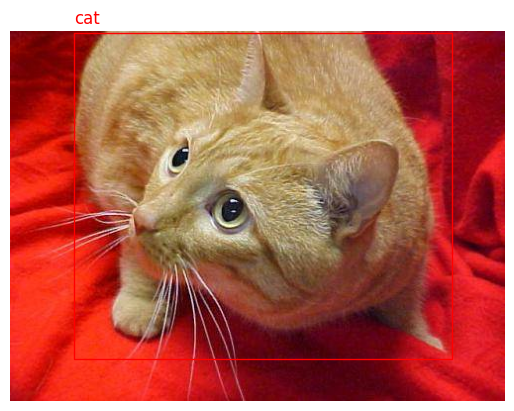

In [ ]:
show_image_with_bounding_box(*dset[10])

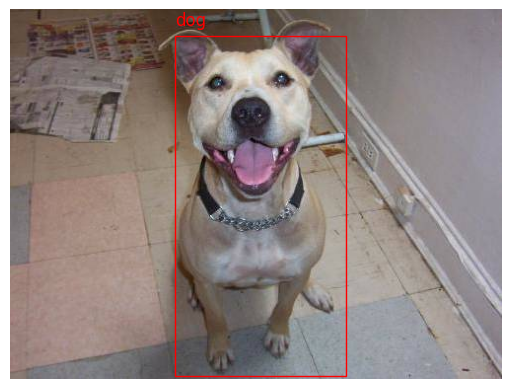

In [ ]:
show_image_with_bounding_box(*dset[-18])

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn

In [ ]:
from torchvision.models import resnet50
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet50(weights='IMAGENET1K_V1')
        self.backbone.requires_grad_(False)
        self.classifier = nn.Linear(in_features=1000, out_features=2)
        self.regressor = nn.Linear(in_features=1000, out_features=4)

    def forward(self, X):
        out = self.backbone(X)
        reg = self.regressor(out)
        clas = self.classifier(out)
        return reg, clas

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [ ]:
import torch as th

In [ ]:
!pip install torchmetrics
import torch.optim as optim
import torchmetrics

In [ ]:
import torchvision.models as models
from torchtext.transforms import LabelToIndex
dset = AnimalDetectionDataset(root,
      transforms=models.ResNet50_Weights.IMAGENET1K_V1.transforms(),
      return_scaled=False,
      target_transform=TT.Sequential(TT.LabelToIndex(['cat', 'dog']), TT.ToTensor())
      )

In [ ]:
from torch.utils.data import DataLoader, random_split

train_dset, test_dset = random_split(dset, lengths=[0.8, 0.2])
train_loader = DataLoader(train_dset, batch_size=64)
test_loader = DataLoader(test_dset, batch_size=64)

In [ ]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
model = Model().to(device=device)

n_epochs = 10
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)

mse = nn.MSELoss()
cel = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    losses = []
    test_losses = []
    for X, y, z in train_loader:
        reg, clas = model(X.to(device=device))
        bbox = [t.unsqueeze(1) for t in z.values()]
        bbox = th.cat(bbox, dim=1).type(th.float32)
        loss_mse = mse(reg, bbox.to(device=device))
        loss_cel = cel(clas, y.squeeze(1).to(device=device))
        loss = loss_mse + loss_cel
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    print('epoch= ', epoch, 'loss= ', th.tensor(losses).mean().item())
    model.eval()
    for X_test, y_test, z_test in train_loader:
        reg, clas = model(X_test.to(device=device))
        bbox = [t.unsqueeze(1) for t in z_test.values()]
        bbox = th.cat(bbox, dim=1).type(th.float32)
        loss_mse = mse(reg, bbox.to(device=device))
        loss_cel = cel(clas, y_test.squeeze(1).to(device=device))
        loss_test = loss_mse + loss_cel
        test_losses.append(loss_test)
    print('epoch= ', epoch, 'test loss= ', th.tensor(test_losses).mean().item())

epoch=  0 loss=  52769.73046875
epoch=  0 test loss=  38710.00390625
epoch=  1 loss=  29965.837890625
epoch=  1 test loss=  21600.857421875
epoch=  2 loss=  17181.70703125
epoch=  2 test loss=  13412.0390625
epoch=  3 loss=  11808.7392578125
epoch=  3 test loss=  10424.8671875
epoch=  4 loss=  9810.5166015625
epoch=  4 test loss=  9135.27734375
epoch=  5 loss=  8738.7158203125
epoch=  5 test loss=  8235.2861328125
epoch=  6 loss=  7922.08642578125
epoch=  6 test loss=  7516.76318359375
epoch=  7 loss=  7272.21875
epoch=  7 test loss=  6945.70263671875
epoch=  8 loss=  6751.65771484375
epoch=  8 test loss=  6480.88525390625
epoch=  9 loss=  6323.24462890625
epoch=  9 test loss=  6093.44189453125


In [ ]:
def inverse_normalize(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return tensor
img = inverse_normalize(dset[3][0], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

{'xmin': 71.96101379394531, 'ymin': 23.695363998413086, 'xmax': 363.9269714355469, 'ymax': 338.328369140625}


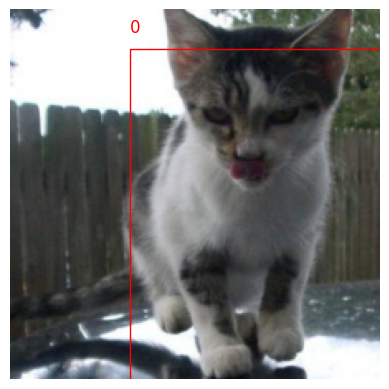

In [ ]:
out = model(dset[3][0].unsqueeze(0).to(device=device))
coords = ['xmin', 'ymin', 'xmax', 'ymax']
d = {}
d['xmin'] = out[0][0][0].item()
d['ymin'] = out[0][0][1].item()
d['xmax'] = out[0][0][2].item()
d['ymax'] = out[0][0][3].item()
print(d)
show_image_with_bounding_box(img, out[1].argmax().item(), d)

{'xmin': 16.61271095275879, 'ymin': 7.722074508666992, 'xmax': 189.95042419433594, 'ymax': 201.7982177734375}


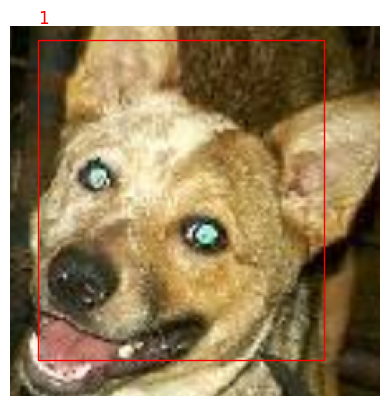

In [ ]:
img = inverse_normalize(dset[-15][0], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
out = model(dset[-15][0].unsqueeze(0).to(device=device))
coords = ['xmin', 'ymin', 'xmax', 'ymax']
d = {}
d['xmin'] = out[0][0][0].item()
d['ymin'] = out[0][0][1].item()
d['xmax'] = out[0][0][2].item()
d['ymax'] = out[0][0][3].item()
print(d)
show_image_with_bounding_box(img, out[1].argmax().item(), d)

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

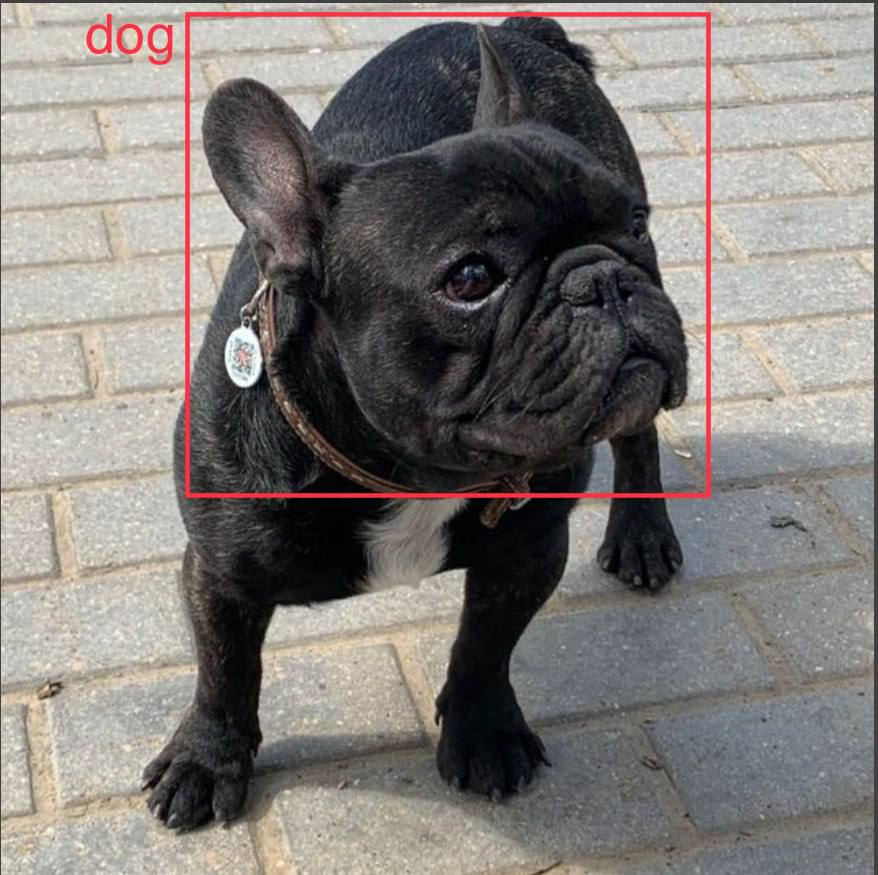

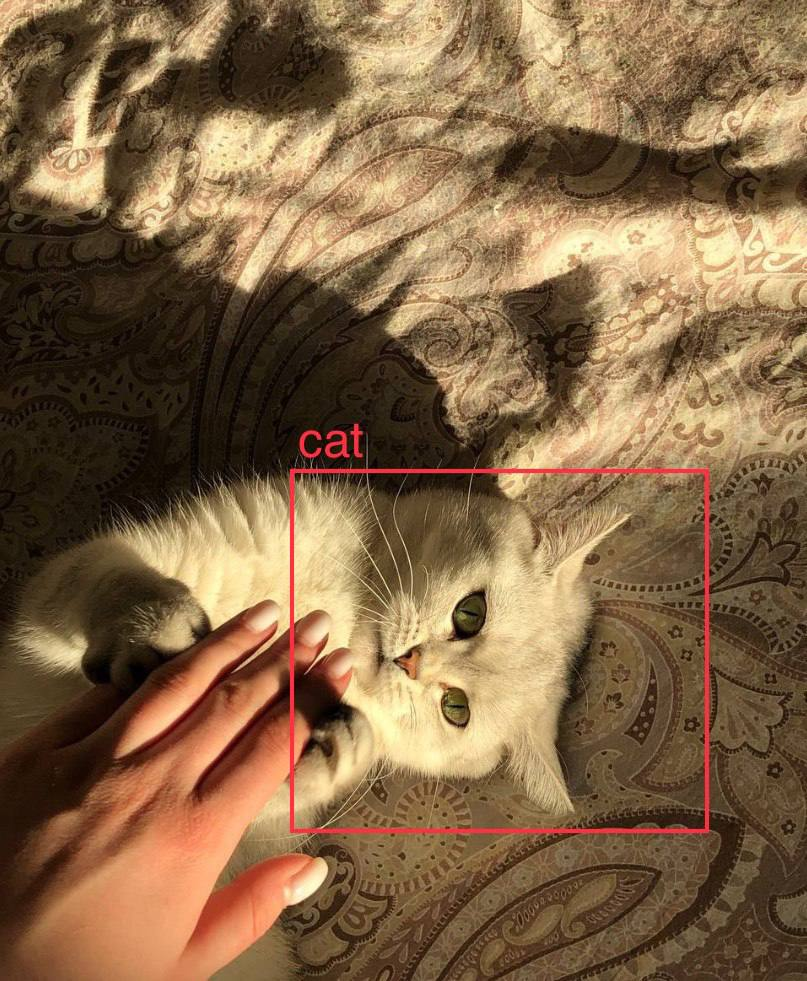

In [ ]:
pic = Image.open('/content/dog.jpg')
transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
pic_t = transforms(pic)

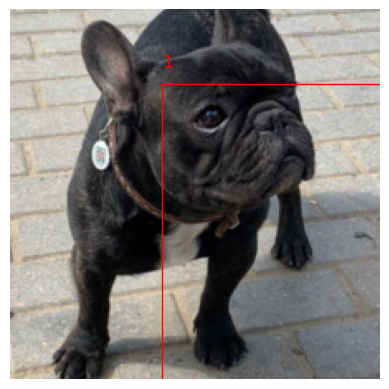

In [ ]:
out = model(pic_t.unsqueeze(0).to(device=device))
pic_t = inverse_normalize(pic_t, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
d = {}
d['xmin'] = out[0][0][0].item()
d['ymin'] = out[0][0][1].item()
d['xmax'] = out[0][0][2].item()
d['ymax'] = out[0][0][3].item()
show_image_with_bounding_box(pic_t, out[1].argmax().item(), d)

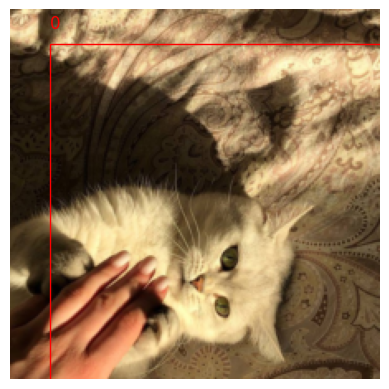

In [ ]:
pic = Image.open('/content/cat.jpg')
transforms = models.ResNet50_Weights.IMAGENET1K_V1.transforms()
pic_t = transforms(pic)

out = model(pic_t.unsqueeze(0).to(device=device))
pic_t = inverse_normalize(pic_t, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
d = {}
d['xmin'] = out[0][0][0].item()
d['ymin'] = out[0][0][1].item()
d['xmax'] = out[0][0][2].item()
d['ymax'] = out[0][0][3].item()
show_image_with_bounding_box(pic_t, out[1].argmax().item(), d)

<p class="task" id="7"></p>

7*\. Повторите решение предыдущей задачи, используя модель `fasterrcnn_resnet50_fpn`. Замените слой для предсказания bounding box на `FastRCNNPredictor` с нужным количеством классов.

- [ ] Проверено на семинаре

## Обратная связь
- [x] Хочу получить обратную связь по решению